In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import scanpy as sc
import scvelo as scv
import scipy as scp
import pandas as pd
import anndata as ad
import numpy as np
scv.logging.print_version()

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.1.24 (python 3.7.3) on 2020-01-29 11:43.


In [10]:
adata = scv.read('finalConcatanatedData.h5ad')
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.8 0.2]


AnnData object with n_obs × n_vars = 23585 × 60623 
    layers: 'spliced', 'unspliced'

In [59]:
# remove duplicated values that have different conditions
phenoDat = pd.read_csv('phenoSCCall.csv')
phenoDat.drop('Unnamed: 0',axis=1, inplace=True)
print(phenoDat.shape)
dup = phenoDat.duplicated('barcodes',keep=False)
dupPhenoDat = phenoDat.loc[dup,:]
dup2 = dupPhenoDat.duplicated(['barcodes','treatment'],keep=False)
dupKeep = dupPhenoDat.loc[dup2,:].sort_values('barcodes')
remove = [x for x in list(dupPhenoDat.index) if x not in list(dupKeep.index)]
pD = phenoDat.drop(remove,axis = 0)
print(pD.shape)
len(set(pD['barcodes']))

(23914, 4)
(23573, 4)


23415

In [20]:
remove = []
for i,obsName in enumerate(adata.obs.index):
    if obsName not in list(pD['barcodes']):
        remove.append(i)
remove

[425,
 459,
 468,
 473,
 616,
 640,
 687,
 1019,
 1068,
 1103,
 1374,
 1503,
 1509,
 1580,
 1616,
 1636,
 1972,
 2102,
 2399,
 2413,
 2442,
 2647,
 3225,
 3414,
 3506,
 3537,
 3968,
 4142,
 4383,
 4446,
 4483,
 4755,
 4853,
 4869,
 5004,
 5275,
 5285,
 5503,
 5562,
 5621,
 5832,
 5905,
 5987,
 5989,
 6290,
 6316,
 6389,
 6861,
 6871,
 6971,
 7076,
 7240,
 7506,
 7539,
 7551,
 7621,
 7799,
 7873,
 7929,
 8018,
 8055,
 8100,
 8232,
 8353,
 8362,
 8613,
 8618,
 8916,
 9028,
 9291,
 9428,
 9493,
 9676,
 9693,
 9712,
 9750,
 9772,
 9778,
 9925,
 9981,
 9982,
 10006,
 10282,
 10293,
 10321,
 10648,
 10969,
 11547,
 11644,
 11771,
 12077,
 12329,
 12338,
 12400,
 12676,
 12731,
 12882,
 12956,
 12995,
 13027,
 13112,
 13202,
 13219,
 13280,
 13395,
 13513,
 13591,
 14232,
 14491,
 14497,
 14568,
 14731,
 15163,
 15205,
 15329,
 15424,
 15766,
 15902,
 16311,
 16326,
 16478,
 16497,
 16531,
 16539,
 16584,
 16690,
 16965,
 17214,
 17307,
 17330,
 17348,
 17475,
 17704,
 17944,
 18224,
 18631,


In [26]:
#remove these indices
X = adata.X.toarray()
X = np.delete(X,remove,axis=0)
X = scp.sparse.csr_matrix(X)
S = adata.layers['spliced'].toarray()
S = np.delete(S,remove,axis=0)
S = scp.sparse.csr_matrix(S)
U = adata.layers['unspliced'].toarray()
U = np.delete(U,remove,axis=0)
U = scp.sparse.csr_matrix(U)

In [30]:
obsNames = [x for i,x in enumerate(adata.obs.index) if i not in remove]
var_names = list(adata.var.index)
concatAdata = ad.AnnData(X,
              {'obs_names': obsNames},
              {'var_names': var_names},
               layers={'spliced':S,
                      'unspliced':U})
filename = 'finalCleanConcatanatedData.h5ad'
print('final adata is:')
print(concatAdata)
print('writing file ' + filename)
concatAdata.write(filename)

final adata is:
AnnData object with n_obs × n_vars = 23415 × 60623 
    layers: 'spliced', 'unspliced'
writing file finalCleanConcatanatedData.h5ad


In [60]:
adata = ad.read_h5ad('finalCleanConcatanatedData.h5ad')
adata

AnnData object with n_obs × n_vars = 23415 × 60623 
    layers: 'spliced', 'unspliced'

https://scvelo-notebooks.readthedocs.io/DentateGyrus.html

In [61]:
t2g = pd.read_table('homo_sapiens/transcripts_to_genes.txt',header=None)
t2g.head()

0                   1       2
0  ENST00000003583.12  ENSG00000001460.18   STPG1
1   ENST00000003912.7  ENSG00000001461.17  NIPAL3
2   ENST00000008440.9  ENSG00000010072.16   SPRTN
3   ENST00000009105.5  ENSG00000008118.10  CAMK1G
4  ENST00000010299.10  ENSG00000009780.15  FAM76A

In [62]:
geneNameDict = dict(zip(t2g[1].values,t2g[2].values))
geneNames = []
for geneId in adata.var.index:
    geneNames.append(geneNameDict[geneId])
geneNames[:5]

['STPG1', 'NIPAL3', 'SPRTN', 'CAMK1G', 'FAM76A']

In [63]:
adata.var['gene'] = geneNames
adata.var.head()

gene
index                     
ENSG00000001460.18   STPG1
ENSG00000001461.17  NIPAL3
ENSG00000010072.16   SPRTN
ENSG00000008118.10  CAMK1G
ENSG00000009780.15  FAM76A

In [64]:
cell = []
pD = pD.set_index('barcodes')

In [65]:
cellDict = dict(zip(pD.index.values,pD['cell'].values))
treatmentDict = dict(zip(pD.index.values,pD['treatment'].values))
replicateDict = dict(zip(pD.index.values,pD['replicate'].values))
cells = []
treatments = []
replicates = []
for barcode in adata.obs.index:
    cells.append(cellDict[barcode])
    treatments.append(treatmentDict[barcode])
    replicates.append(treatmentDict[barcode])

In [66]:
adata.obs['cell'] = cells
adata.obs['treatment'] = treatments
adata.obs['replicate'] = replicates
adata

AnnData object with n_obs × n_vars = 23415 × 60623 
    obs: 'cell', 'treatment', 'replicate'
    var: 'gene'
    layers: 'spliced', 'unspliced'

In [67]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 45992 genes that are detected in less than 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:10) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:07) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [68]:
adata

AnnData object with n_obs × n_vars = 23415 × 2000 
    obs: 'cell', 'treatment', 'replicate', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'

In [69]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:12) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [70]:
scv.tl.velocity_graph(adata)
adata

computing velocity graph
    finished (0:02:37) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


AnnData object with n_obs × n_vars = 23415 × 2000 
    obs: 'cell', 'treatment', 'replicate', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'gene', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'

In [72]:
sc.tl.umap(adata)

In [73]:
adata.write_h5ad('finalCleanadataWithVelocity.h5ad')

saving figure to file ./figures/scvelo_velocityStream.png


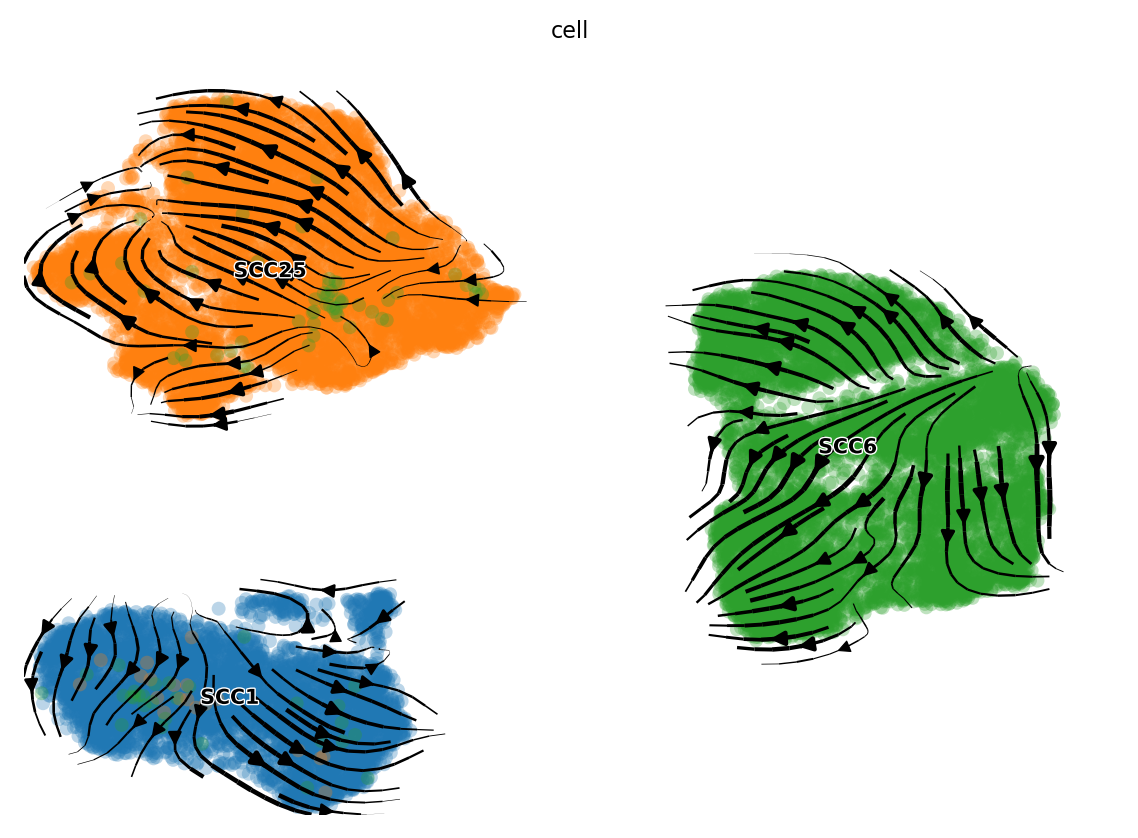

In [76]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='cell',save='velocityStream.png')

saving figure to file ./figures/scvelo_velocityStreamTreatment.png


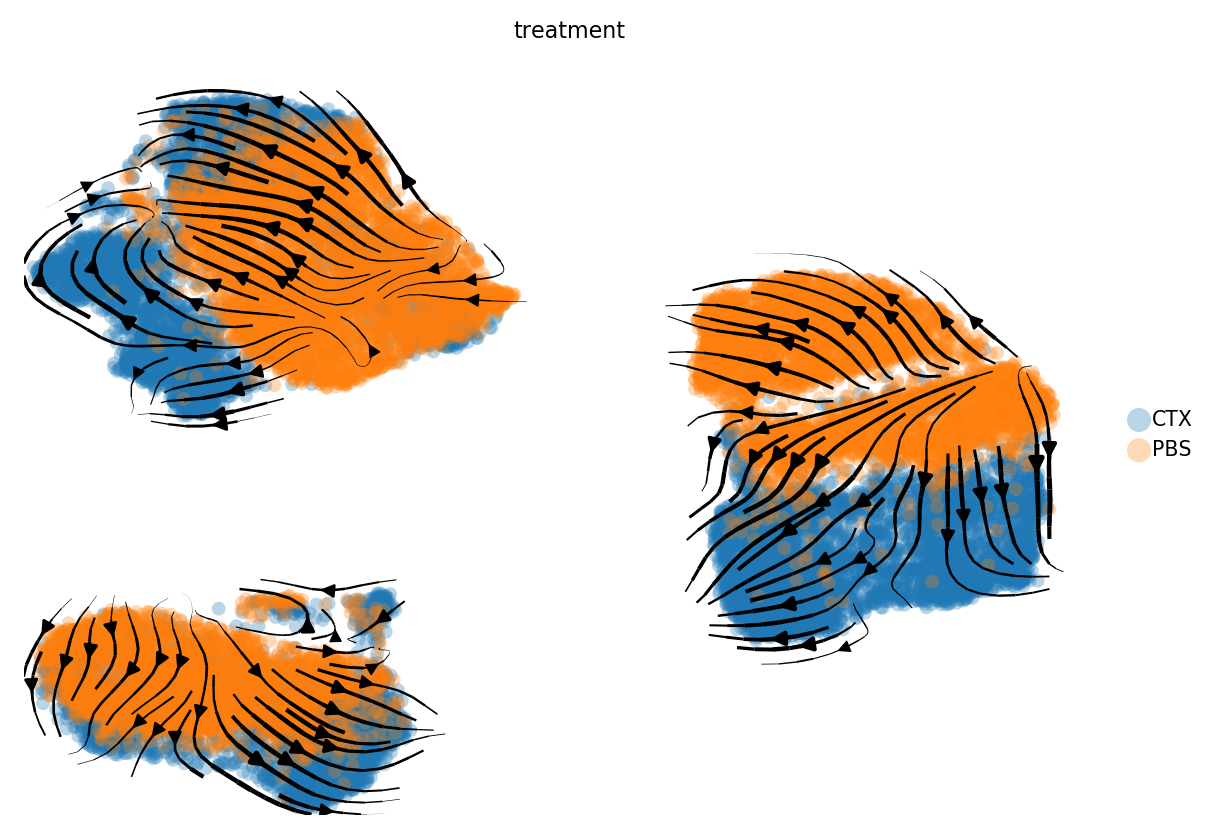

In [85]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='treatment',save='velocityStreamTreatment.png',legend_loc='right margin')

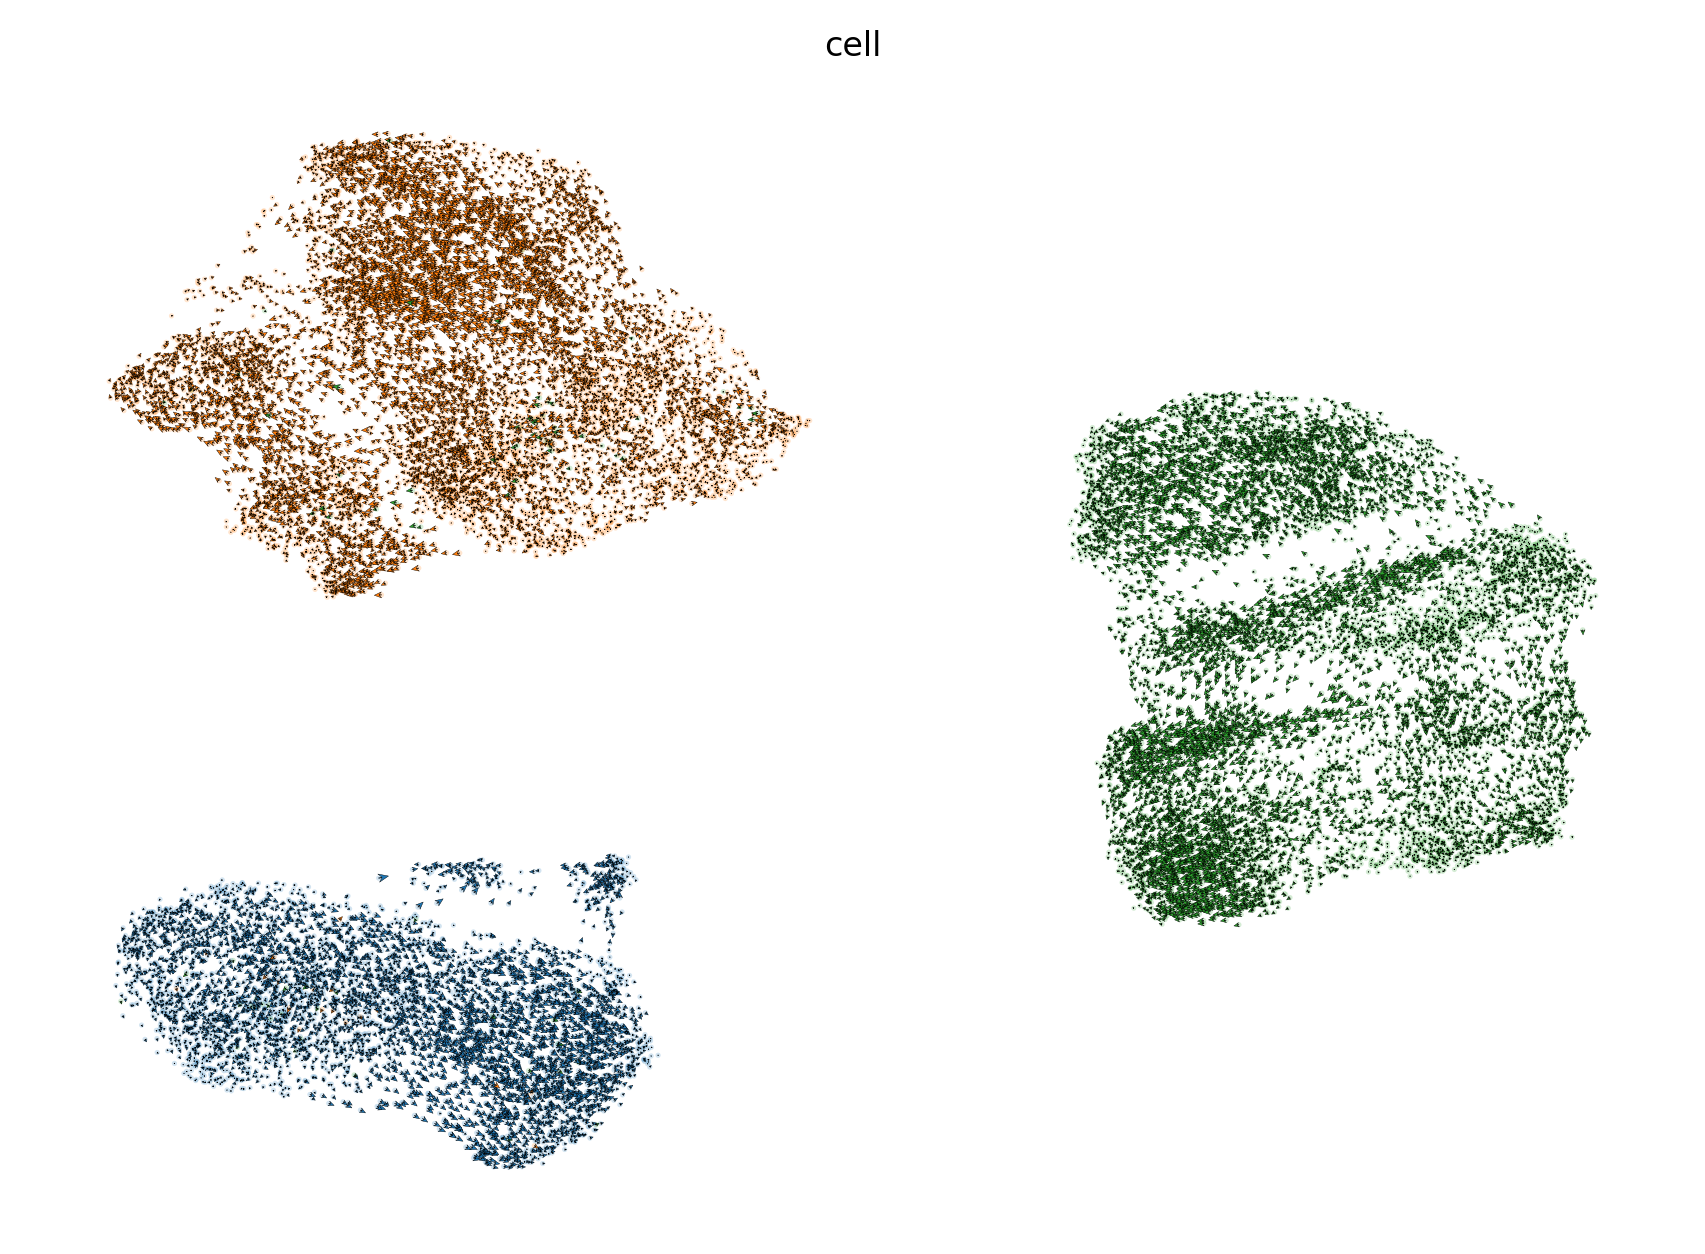

In [80]:
scv.pl.velocity_embedding(adata, basis='umap', arrow_length=2, arrow_size=1.5, dpi=150,color='cell')

In [81]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (1:01:32) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [82]:
adata.write_h5ad('finalCleanWithDynamics.h5ad')

In [ ]:
df = adata.var
df.head()
df['geneId'] = df.index
df = df.set_index('gene')
df.head()
adata.var = df

In [83]:
adata

AnnData object with n_obs × n_vars = 23415 × 2000 
    obs: 'cell', 'treatment', 'replicate', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'gene', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling'
    uns: 'pca', 'neighbors', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg', 'cell_colors', 'treatment_colors', 'recover_dynamics'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity', 'fit_t', 'fit_tau', 'fit_tau_'

In [96]:
scv.tl.recover_latent_time(adata)

computing latent time
    finished (0:00:13) --> added 
    'latent_time', shared time (adata.obs)


saving figure to file ./figures/scvelo_latentTime.png


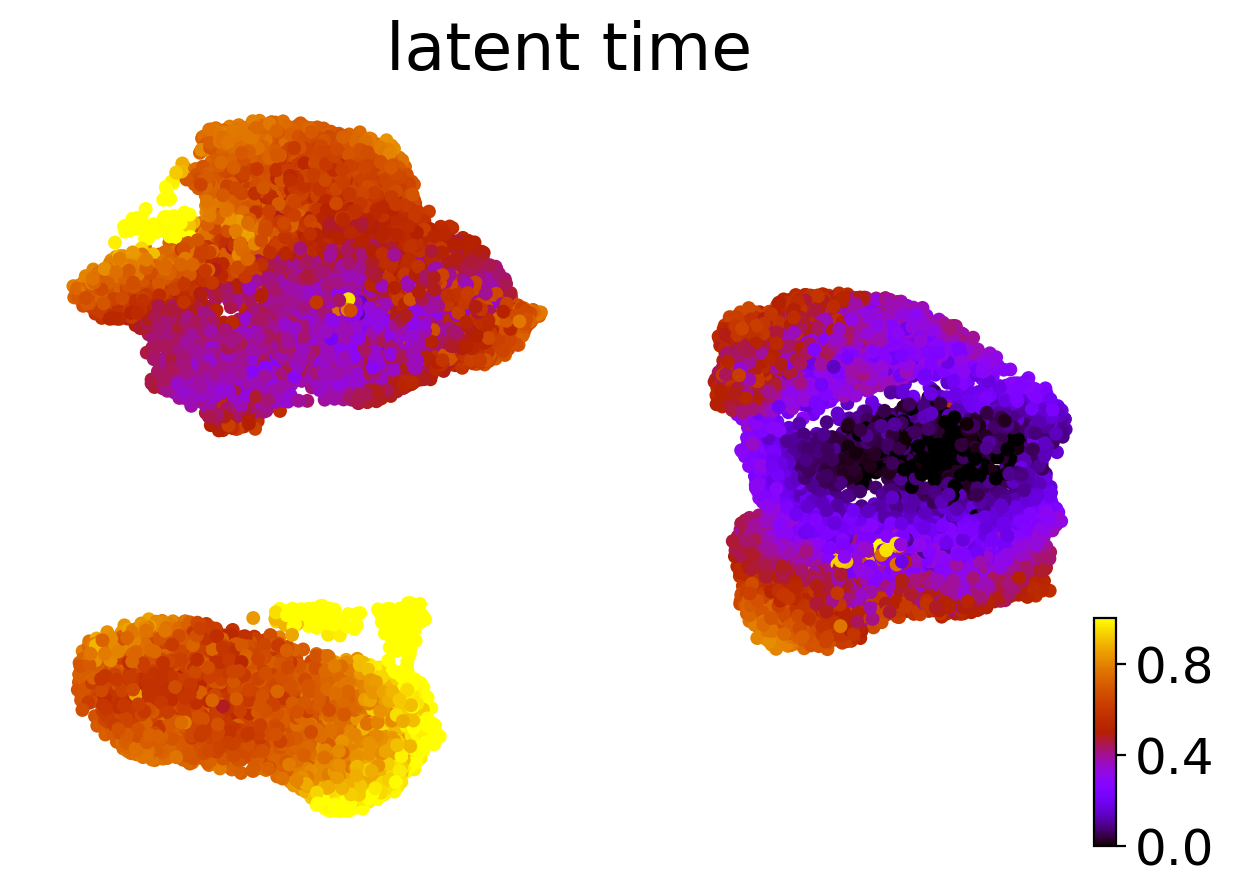

In [97]:
scv.pl.scatter(adata, color='latent_time', fontsize=24, size=100,
               color_map='gnuplot', perc=[2, 98], colorbar=True, rescale_color=[0,1],save='latentTime.png')

saving figure to file ./figures/scvelo_heatmap_topGenesColorCell.png


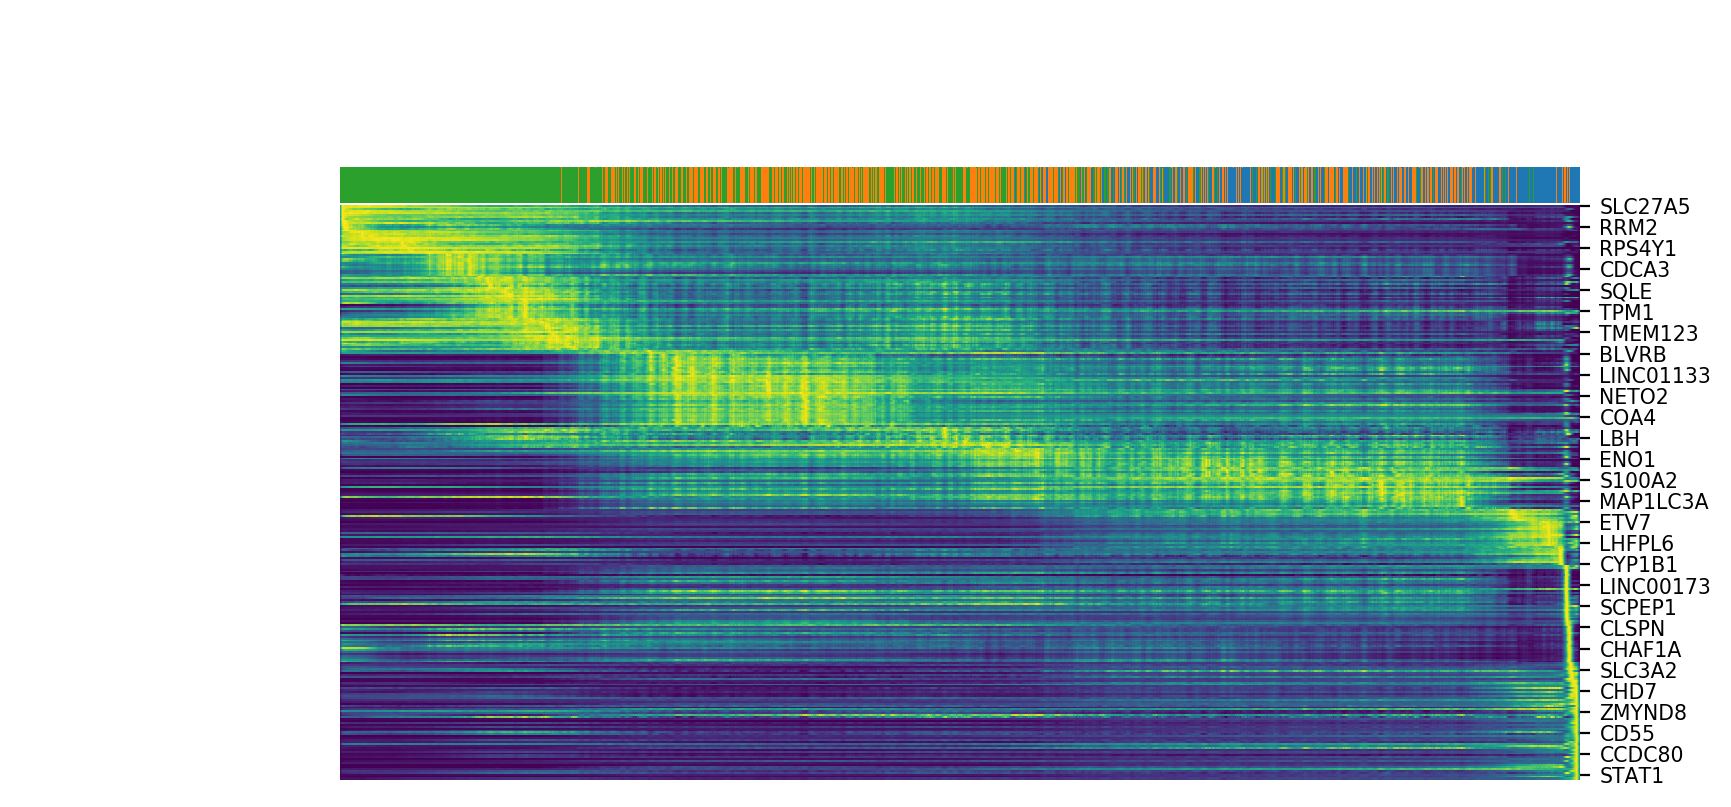

In [100]:
top_genes = adata.var_names[adata.var.fit_likelihood.argsort()[::-1]][:300]
scv.pl.heatmap(adata, var_names=top_genes, tkey='latent_time', n_convolve=100, col_color='cell',save='topGenesColorCell.png')

saving figure to file ./figures/scvelo_top5-10genesColByTreatment.png


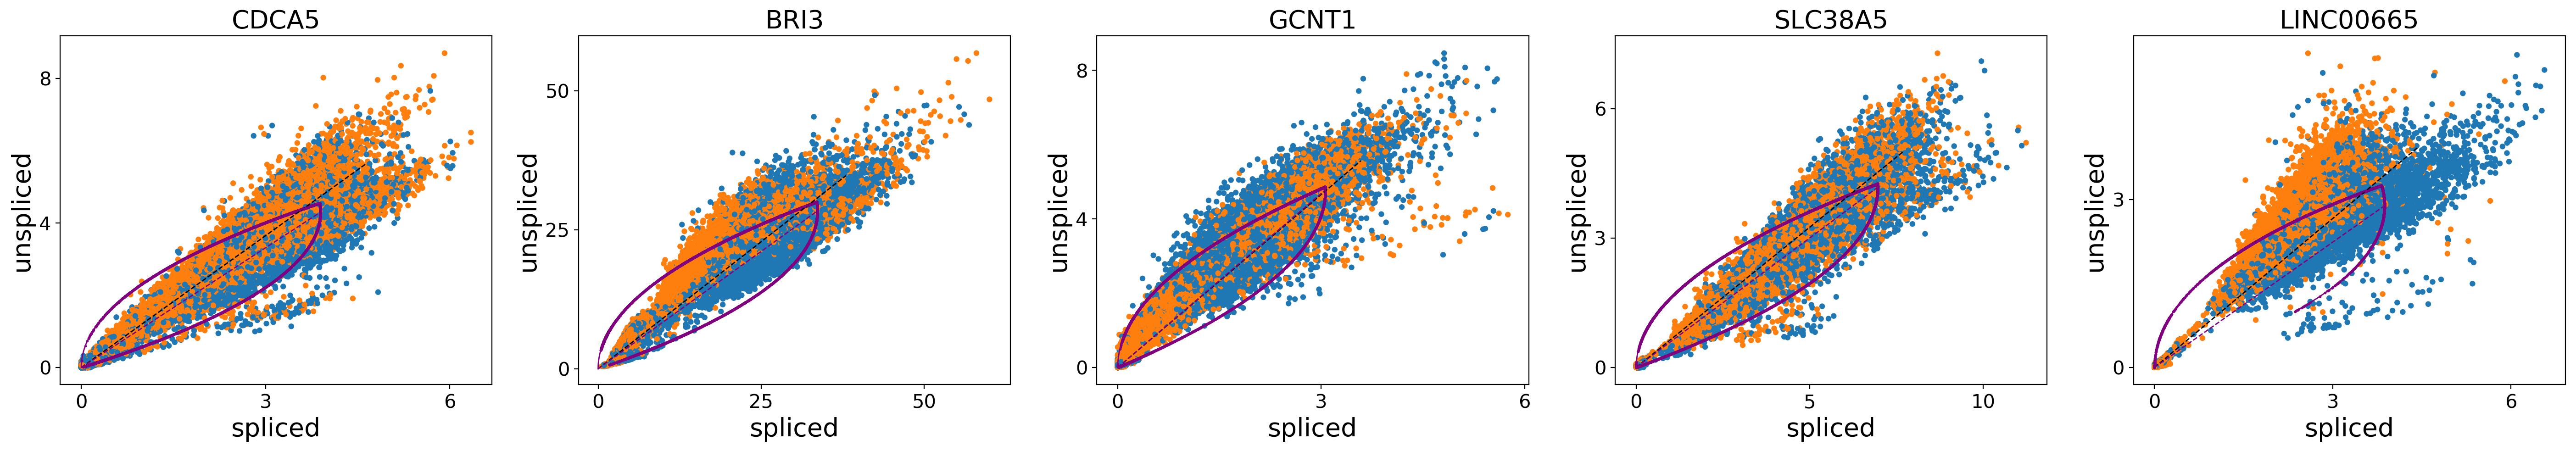

In [114]:
scv.pl.scatter(adata, basis=top_genes[5:10], legend_loc='none',
               size=80, frameon=True, ncols=5, fontsize=20,color='treatment',save='top5-10genesColByTreatment.png')

saving figure to file ./figures/scvelo_top5-10GenesColByCell.png


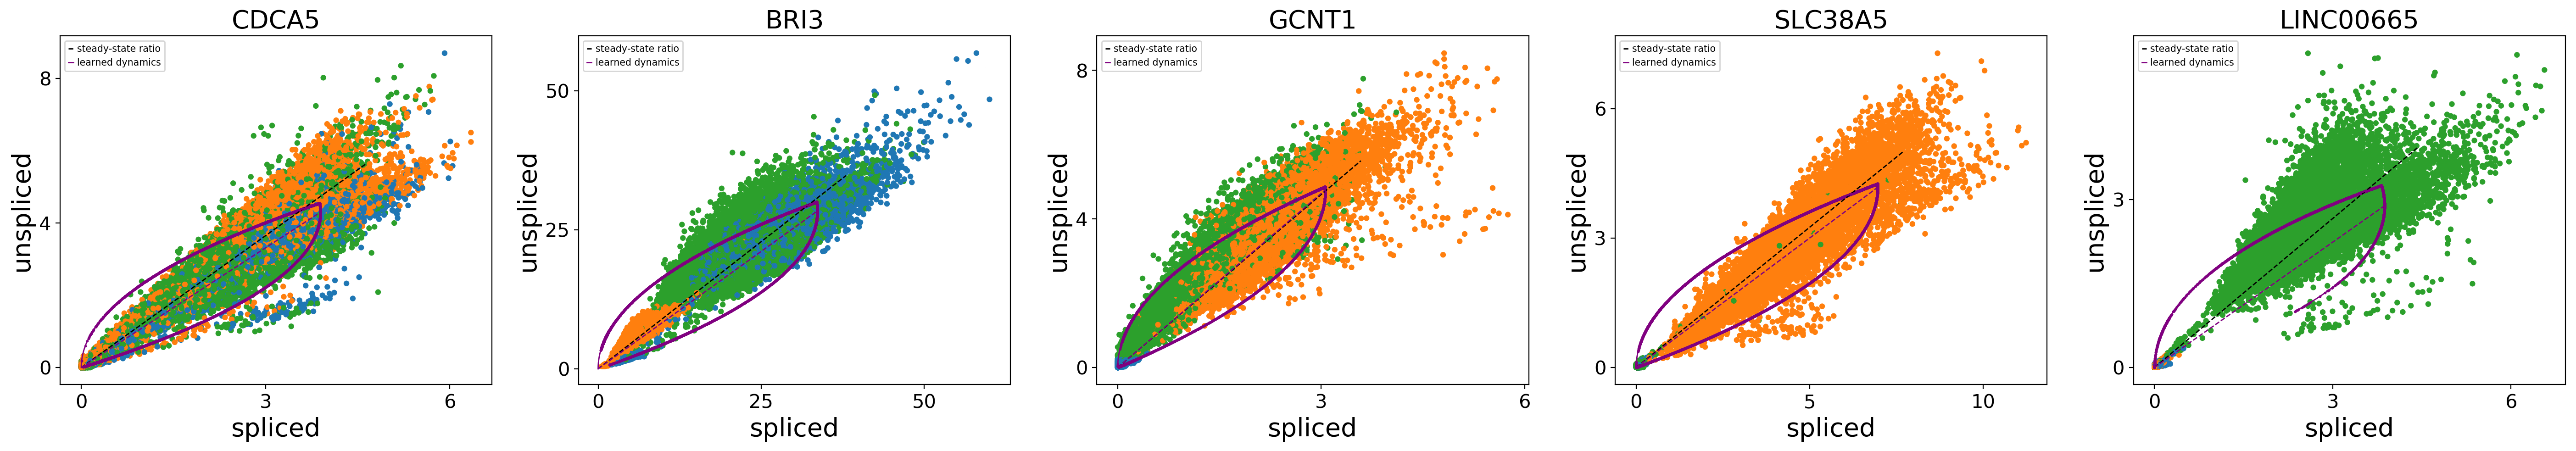

In [115]:
scv.pl.scatter(adata, basis=top_genes[5:10], legend_loc='right margin',
               size=80, frameon=True, ncols=5, fontsize=20,color='cell',save='top5-10GenesColByCell.png')

saving figure to file ./figures/scvelo_velocityStreamLatentTime.png


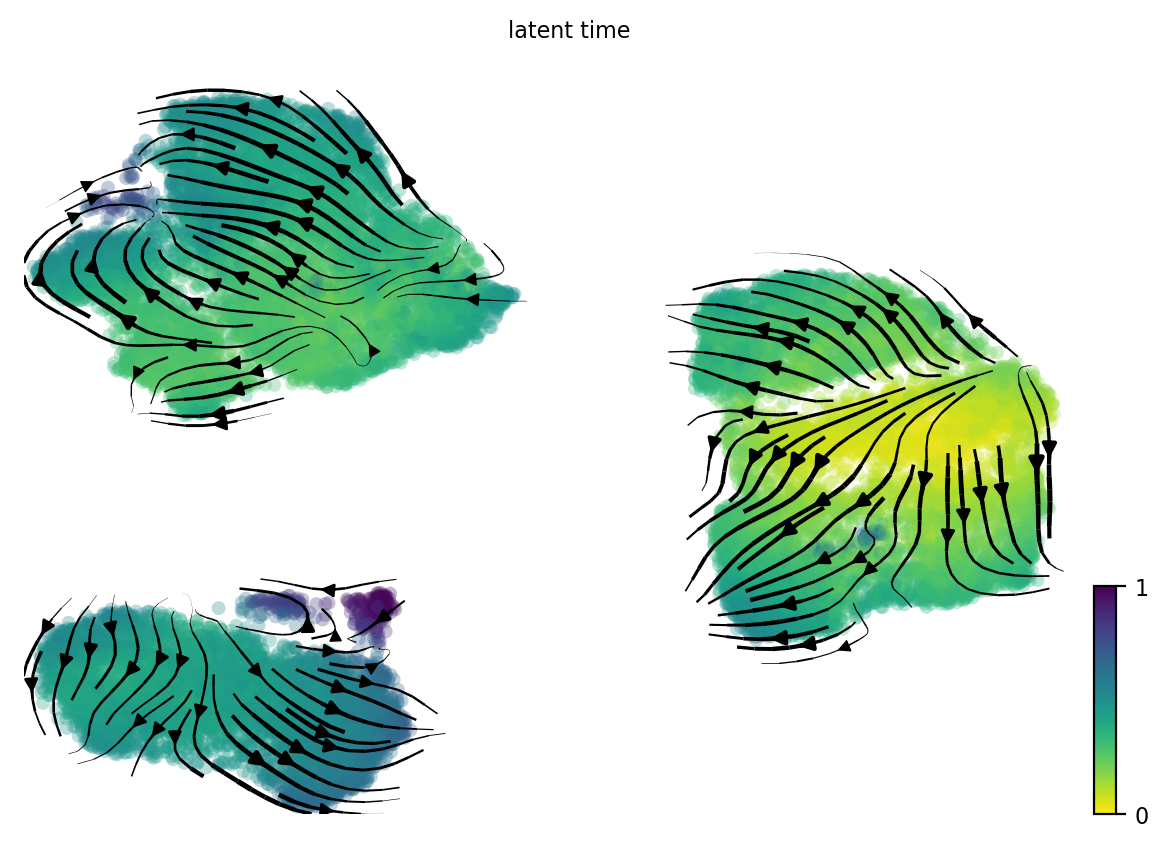

In [117]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='latent_time',save='velocityStreamLatentTime.png',legend_loc='right margin')

saving figure to file ./figures/scvelo_velocityStreamVelocityPseudoTime.png


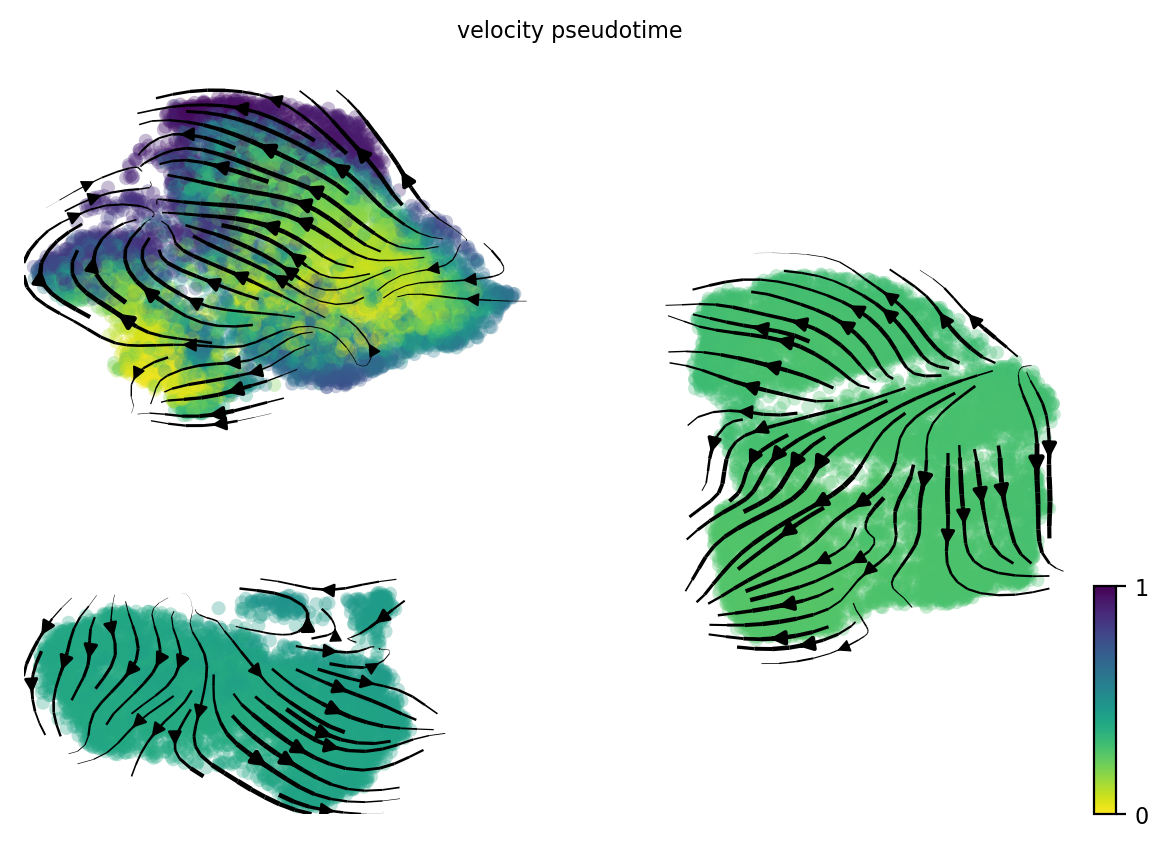

In [119]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color='velocity_pseudotime',save='velocityStreamVelocityPseudoTime.png',legend_loc='right margin')

In [125]:
adata.var.fit_likelihood.argsort()[::-1][:300]

gene
PRKY           1030
ZNF736P9Y      1996
LINC00278       997
RPS4Y1          426
AC006062.1      874
AC002377.1      328
SPANXA2-OT1    1722
MIR222HG       1914
SLC6A14        1983
LINC02595      1010
LINC01456       906
AC110995.1      406
AC107419.1      394
FTX            1003
XIST           1672
MIR503HG       1865
SLC38A5         374
LINC02154       314
PIR            1230
CA5BP1          332
GRPR           1155
MAP7D2          304
SAT1            415
MAOB            181
KIF4A          1144
OGT             529
PBDC1          1203
BEX2           1967
SMARCA1        1928
GPC4           1874
               ... 
ATP6V0A4       1580
CD36           1451
CYP2W1           68
GUSB            366
MCM7             19
ZNF467           95
SUN3            455
BRI3           1999
COL1A2         1684
SHH            1918
SLC29A4        1625
PDIA4          1325
AKR1B1         1970
SEMA3D          523
ZNF117          552
GIGYF1         1527
IGFBP3           37
ANLN            747
SEMA3C         